# Proyecto 2: Procesamiento de lenguaje natural con tweets de desastres

- Marco Fuentes - 18188
- Andy Castillo - 18040
- Francisco Rosal - 18676
- Gian Luca Rivera - 18049

## Situación problemática
Hoy en día las redes sociales son un medio de comunicación que utilizan la mayoría de personas en todo el mundo en su día a día. Considerando las redes sociales nos permiten para transmitir un mensaje de forma sencilla y el gran alcance que tienen, las redes sociales pueden ser una fuente de información muy importante. Estas pueden ser muy útiles al momento de querer informar sobre alguna situtación crítica, como en este caso algún desastre, ya sea natural o provocado, en donde se necesita que las personas estén informadas lo más rápido posible. No todas las redes sociales están diseñadas para poder informar de una forma tan rápida, sin embargo redes sociales como twitter si nos pueden ayudar a este propósito.

## Problema científico
Twitter se ha convertido en un importante canal de comunicación en tiempos de emergencia. La ubicuidad de los teléfonos inteligentes permite a las personas anunciar una emergencia que están observando en tiempo real. Debido a esto, más agencias (organizaciones de socorro, agencias de noticias) están interesadas en monitorear programáticamente Twitter, sin embargo, no siempre está claro si las palabras de una persona realmente anuncian un desastre.


## Objetivo general
- Crear modelos de aprendizaje automático que permita predecir qué tweets son sobre desastres reales y cuáles no.

## Objetivos específicos
- Analizar los tweets para poder diferenciar entre los que son sobre desastres y los que no.
- Probar diferentes algoritmos con diferentes parámetros para determinar cuales son los modelos más precisos.


## Librerias

In [82]:
import re
import folium
import numpy as np
import pandas as pd
import transformers
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from tensorflow.keras.models import Model
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input
from geopy.extra.rate_limiter import RateLimiter
from tensorflow.keras.callbacks import ModelCheckpoint

## Datos

El dataset cuenta con 5 variables:
- id: identificador unico del tweet
- text: texto del tweet
- ubicación: ubicacion donde se posteo el tweet
- keyword: palabra clave del tweet
- target: 0 si no es caso de desastre real, 1 si es tweet de caso real.

In [55]:
data = pd.read_csv("train.csv")

## Limpieza y preprocesamiento

Verificamos si hay tweets duplicados.

In [56]:
duplicated_data = data['text'].duplicated().sum()
print(f'Existen {duplicated_data} tweets duplicados')

Existen 110 tweets duplicados


Eliminamos los tweets duplicados ya que representan una pequeña parte del total de tweets.

In [57]:
data = data.drop_duplicates(subset=['text'], keep='first')

Eliminamos locations NA

In [58]:
data['location'].replace('', np.nan, inplace=True)
data = data.dropna(subset=['location'])

Convertimos todo el texto del tweet a minuscula, eliminamos los hipervinculos y caracteres especiales para que no esten las menciones ni los hashtag.

In [59]:
def clean_data(text):
    text = text.lower()
    text = re.sub(r'http[s]?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = " ".join(text.split())
    return text

In [60]:
def clean_data_locations(text):
    text = str(text)
    text = re.sub(r'http[s]?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    text = " ".join(text.split())
    return text

In [61]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )

    return emoji_pattern.sub(r'', text)

In [62]:
data['text'] = data['text'].apply(clean_data)

In [63]:
data['text'] = data['text'].apply(remove_emojis)

In [64]:
data['location'] = data['location'].apply(clean_data_locations)

In [65]:
data['location'] = data['location'].apply(remove_emojis)

In [66]:
data['location'].replace('', np.nan, inplace=True)
data = data.dropna(subset=['location'])

In [67]:
data['location'] = data['location'].replace({
    "United States": "USA",
    "US": "USA",
    "London, UK": "London",
    "London UK": "London",
    "London.": "London",
    "london": "London",
    "City of London London": "London",
    "London England": "London",
    "London, England": "London",
    "United Kingdom": "UK",
    "England": "UK",
    "uk": "UK",
    "Manchester England": "Manchester",
    "Manchester UK": "Manchester",
    "Atlanta, GA": "Atlanta",
    "NEW YORK": "New York",
    "New York City": "New York",
    "New York USA": "New York",
    "NYC": "New York",
    "NY": "New York",
    "New York NY": "New York",
    "New York, NY": "New York",
    "New York United States": "New York",
    "New Your": "New York",
    "New York Worldwide": "New York",
    "New York NYC": "New York",
    "new york ny": "New York",
    "New York New York": "New York",
    "New York 2099": "New York",
    "New York ATL": "New York",
    "New York City NY": "New York",
    "New JerseyNew York": "New York",
    "NYC New York": "New York",
    "new york": "New York",
    "nyc": "New York",
    "New York / Worldwide" : "New York",
    "New Jersey USA": "New Jersey",
    "New Jersey usually": "New Jersey",
    "New Jersey DR": "New Jersey",
    "San Francisco, CA": "San Francisco",
    "San Francisco CA": "San Francisco",
    "California, USA": "California",
    "California USA": "California",
    "California, United States": "California",
    "California United States": "California",
    "CA": "California",
    "Chicago, IL": "Chicago",
    "Chicago IL": "Chicago",
    "Chicago Illinois": "Chicago",
    "Los Angeles, CA": "Los Angeles",
    "Los Angeles CA": "Los Angeles",
    "L.A.": "Los Angeles",
    "Los Angeles New York": "Los Angeles",
    "Everywhere": "Worldwide",
    "Earth": "Worldwide",
    "Washington, DC": "Washington",
    "Washington DC": "Washington",
    "Washington DC NATIVE": "Washington",
    "Washington state": "Washington",
    "Washington State": "Washington",
    "Washington USA": "Washington",
    "WASHINGTONDC": "Washington",
    "WashingtonState Seattle": "Washington",
    "Western Washington": "Washington",
    "Washington DC area": "Washington",
    "Washington DC 20009": "Washington",
    "washington dc": "Washington",
    "Washington, D.C.": "Washington",
    "Florida, USA" : "Florida",
    "Florida USA" : "Florida",
    "Miami, FL" : "Miami",
    "Miami Florida" : "Miami",
    "Dallas, TX" : "Dallas",
    "Dallas TX" : "Dallas",
    "Austin, Texas" : "Austin",
    "Austin Texas" : "Austin",
    "Austin TX" : "Austin",
    "Houston TX" : "Houston",
    "Arlington TX" : "Arlington",
    "Atlanta GA" : "Atlanta",
    "Atlanta Georgia" : "Atlanta",
    "San Diego CA" : "San Diego",
    "Seattle WA" : "Seattle",
    "Seattle Washington" : "Seattle",
    "SEATTLE WA USA" : "Seattle",
    "WashingtonState Seattle" : "Seattle",
    "seattle wa" : "Seattle",
    "Boston MA" : "Boston",
    "Denver CO" : "Denver",
    "Pennsylvania USA" : "Pennsylvania",
    "Brooklyn NY" : "Brooklyn",
    "Brooklyn New York" : "Brooklyn",
    "New York Brooklyn" : "Brooklyn",
    "New York Connecticut" : "Connecticut",
    "Portland OR": "Portland",
    "Portland Oregon": "Portland",
    "Orlando FL": "Orlando",
    "Tampa FL": "Tampa",
    "Texas USA": "Texas",
    "indiana": "Indiana",
    "Indiana USA": "Indiana",
    "Indianapolis IN": "Indiana",
    "canada" : "Canada",
    "Berlin Germany": "Berlin",
    "Las Vegas Nevada": "Las Vegas",
    "Massachusetts USA": "Massachusetts",
    "Georgia USA": "Georgia",
    "ARGENTINA" : "Argentina",
    "china" : "China",
    "india" : "India",
    "INDIA" : "India",
    "Bangalore INDIA" : "Bangalore",
    "Bangalore India" : "Bangalore",
    "Bangalore City India" : "Bangalore",
    "italy" : "Italy",
    "anzioitaly" : "Italy",
    "ITALY" : "Italy",
    "Rome Italy" : "Rome",
    "CasertaRoma Italy" : "Caserta",
    "Manhattan NY" : "Manhattan",
    "Mumbai India" : "Mumbai",
    "Mumbai india" : "Mumbai",
    "Stockholm Sweden" : "Stockholm",
    "Virginia USA": "Virginia",
    "Auckland New Zealand": "Auckland",
    "Buenos Aires Argentina" : "Buenos Aires",
    "Lagos Nigeria" : "Lagos",
    "nigeria" : "Nigeria",
    "NIGERIA" : "Nigeria",
    "Nigeria Global" : "Nigeria",
    "Nigeria WORLDWIDE" : "Nigeria",
    "Charlotte NC" : "Charlotte",
    "Charlotte County Florida" : "Charlotte",
    "Nashville TN" : "Nashville",
    "Sacramento CA" : "Sacramento",
    "Melbourne Australia" : "Melbourne",
    "Memphis TN" : "Memphis",
    "Calgary Alberta" : "Calgary",
    "Calgary AB Canada" : "Calgary",
    "Calgary Alberta Canada" : "Calgary",
    "Calgary Canada" : "Calgary",
    "CalgaryAB Canada" : "Calgary",
    "caNADA" : "Canada",
    "Canada BC" : "Canada",
    "Canada Eh" : "Canada",
    "Toronto Canada" : "Toronto",
    "Toronto ON Canada" : "Toronto",
    "TorontoCitizen of Canada US" : "Toronto",
    "Vancouver BC Canda" : "Vancouver",
    "Vancouver Canada" : "Vancouver",
    "Victoria BC Canada" : "Victoria",
    "Victoria Canada" : "Victoria",
    "Oklahoma City OK" : "Oklahoma",
    "Ontario Canada" : "Ontario",
    "Newcastle" : "Newcastle Upon Tyne",
    "Newcastle England" : "Newcastle Upon Tyne",
    "Newcastle OK" : "Newcastle Upon Tyne",
    "Newcastle upon Tyne" : "Newcastle Upon Tyne",
    "Newcastle Upon Tyne England" : "Newcastle Upon Tyne",
    "NewcastleuponTyne UK" : "Newcastle Upon Tyne",
    "The Netherlands" : "Netherlands",
    "New Delhi Delhi" : "New Delhi",
    "New Delhi India" : "New Delhi",
    "New DelhiIndia" : "New Delhi",
    "Adelaide Australia" : "Adelaide",
    "Adelaide South Australia" : "Adelaide",
    "Brisbane Australia" : "Brisbane",
    "brisbane australia" : "Brisbane",
    "Gold Coast Australia" : "Gold Coast",
    "Gold Coast Qld Australia" : "Gold Coast",
    "Sydney Australia" : "Sydney",
    "sydney australia" : "Sydney",
})

## Análisis exploratorio

### Dataset general

In [68]:
rows = len(data)
columns = len(data.columns)
print("Columnas: ", columns, " | ", "Filas: ", rows)

Columnas:  5  |  Filas:  4966


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4966 non-null   int64 
 1   keyword   4966 non-null   object
 2   location  4966 non-null   object
 3   text      4966 non-null   object
 4   target    4966 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 232.8+ KB


In [70]:
data.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd wholesale markets ablaze,1
32,49,ablaze,Est September 2012 Bristol,we always try to bring the heavy metal rt,0
33,50,ablaze,AFRICA,africanbaze breaking newsnigeria flag set abla...,1
34,52,ablaze,Philadelphia PA,crying out for more set me ablaze,0
35,53,ablaze,London,on plus side look at the sky last night it was...,0


### Keyword

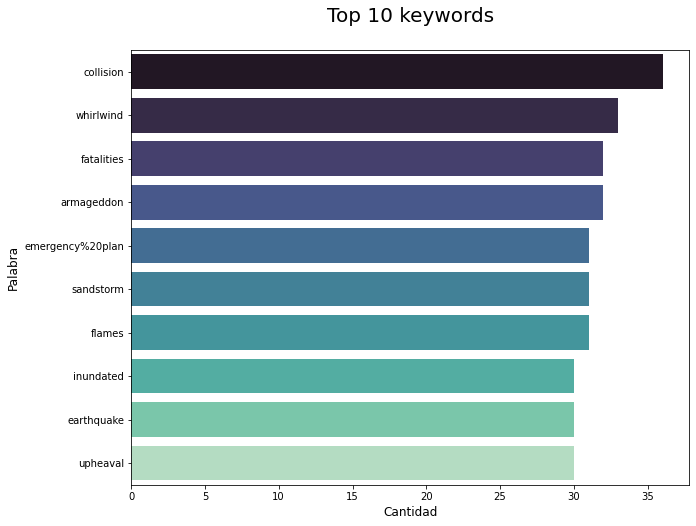

In [71]:
keywords = data['keyword'].value_counts().nlargest(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=keywords.tolist(), y=keywords.index, orient='h', palette='mako')
plt.title('Top 10 keywords\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)
plt.show()

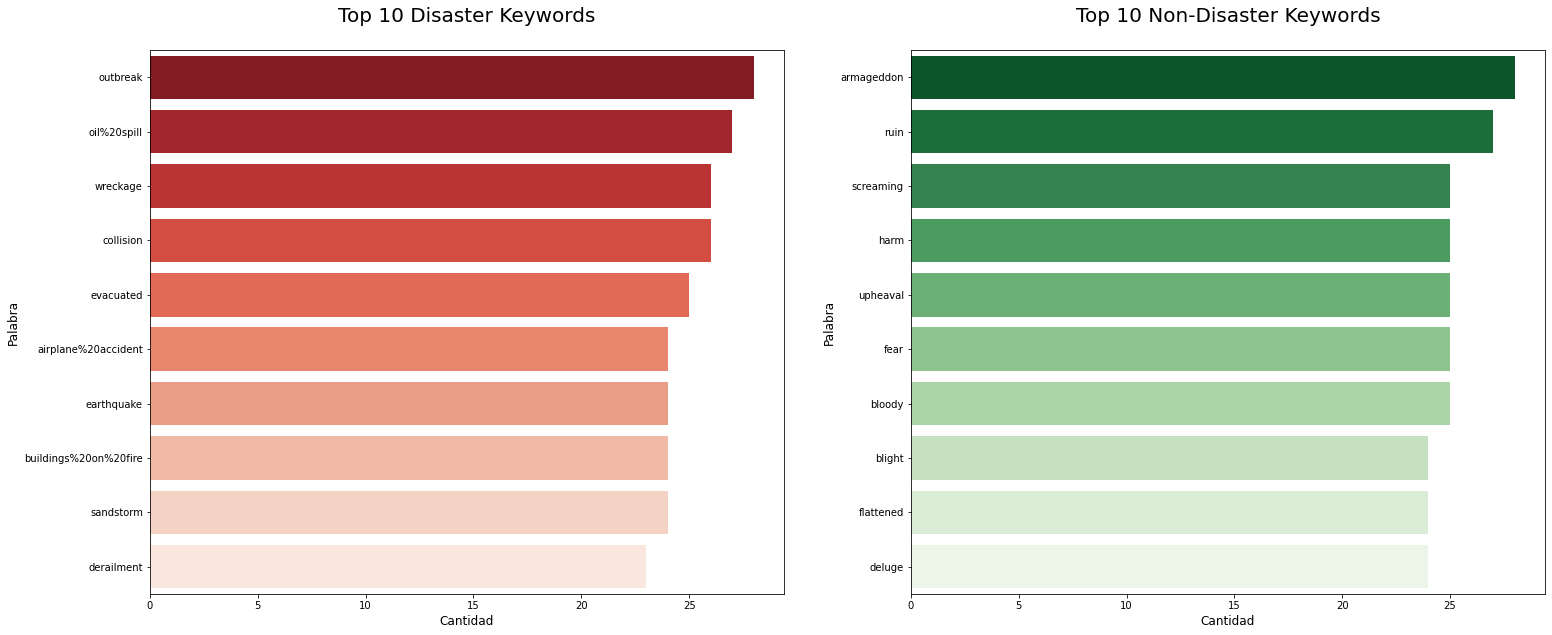

In [72]:
disaster_keywords = data[data['target']==1]['keyword'].value_counts().nlargest(10)
non_disaster_keywords = data[data['target']==0]['keyword'].value_counts().nlargest(10)

fig, ax = plt.subplots(1,2, figsize=(25,10))
sns.barplot(x=disaster_keywords.tolist(), y=disaster_keywords.index, orient='h', palette='Reds_r', ax=ax[0])
sns.barplot(x=non_disaster_keywords.tolist(), y=non_disaster_keywords.index, orient='h', palette='Greens_r', ax=ax[1])

ax[0].set_title('Top 10 Disaster Keywords\n', fontsize=20)
ax[0].set_xlabel('Cantidad', fontsize=12)
ax[0].set_ylabel('Palabra', fontsize=12)

ax[1].set_title('Top 10 Non-Disaster Keywords\n', fontsize=20)
ax[1].set_xlabel('Cantidad', fontsize=12)
ax[1].set_ylabel('Palabra', fontsize=12)
plt.show()

### Location

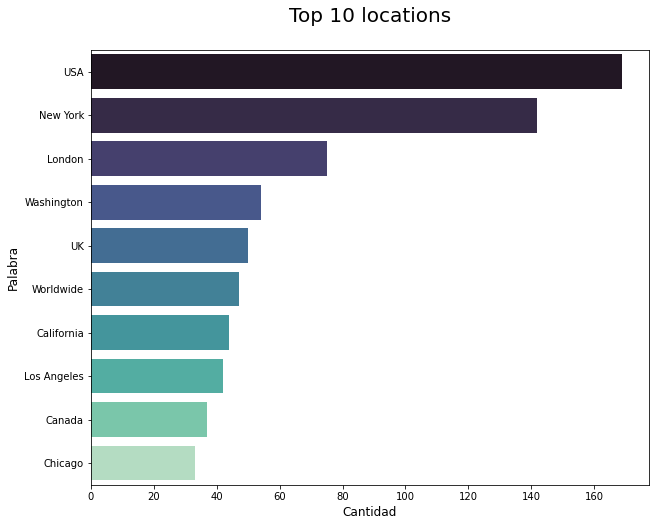

In [73]:
locations = data['location'].value_counts().nlargest(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=locations.tolist(), y=locations.index, orient='h', palette='mako')
plt.title('Top 10 locations\n', fontsize=20)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Palabra', fontsize=12)
plt.show()

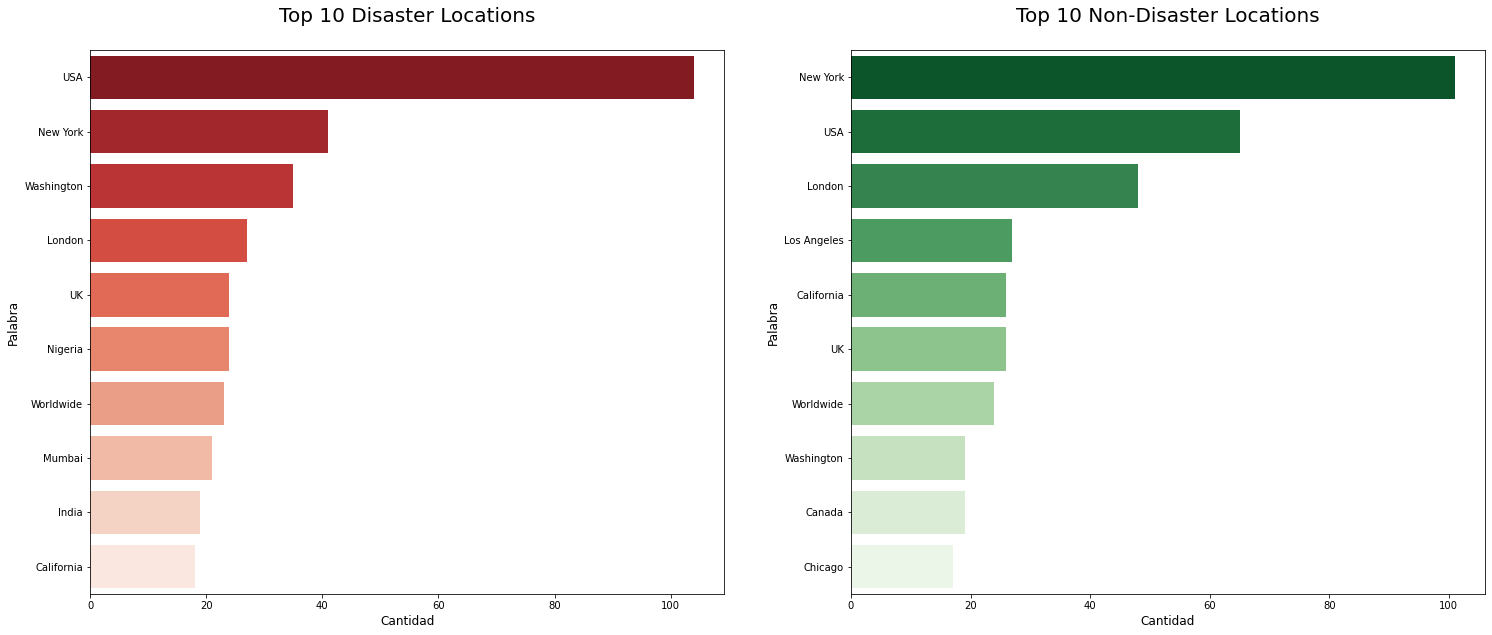

In [74]:
disaster_locations = data[data['target']==1]['location'].value_counts().nlargest(10)
non_disaster_locations = data[data['target']==0]['location'].value_counts().nlargest(10)

fig, ax = plt.subplots(1,2, figsize=(25,10))
sns.barplot(x=disaster_locations.tolist(), y=disaster_locations.index, orient='h', palette='Reds_r', ax=ax[0])
sns.barplot(x=non_disaster_locations.tolist(), y=non_disaster_locations.index, orient='h', palette='Greens_r', ax=ax[1])

ax[0].set_title('Top 10 Disaster Locations\n', fontsize=20)
ax[0].set_xlabel('Cantidad', fontsize=12)
ax[0].set_ylabel('Palabra', fontsize=12)

ax[1].set_title('Top 10 Non-Disaster Locations\n', fontsize=20)
ax[1].set_xlabel('Cantidad', fontsize=12)
ax[1].set_ylabel('Palabra', fontsize=12)
plt.show()

In [75]:
df = data['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="main")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}

for i in df['location'].values:
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude

df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []

for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)

map1

### Text

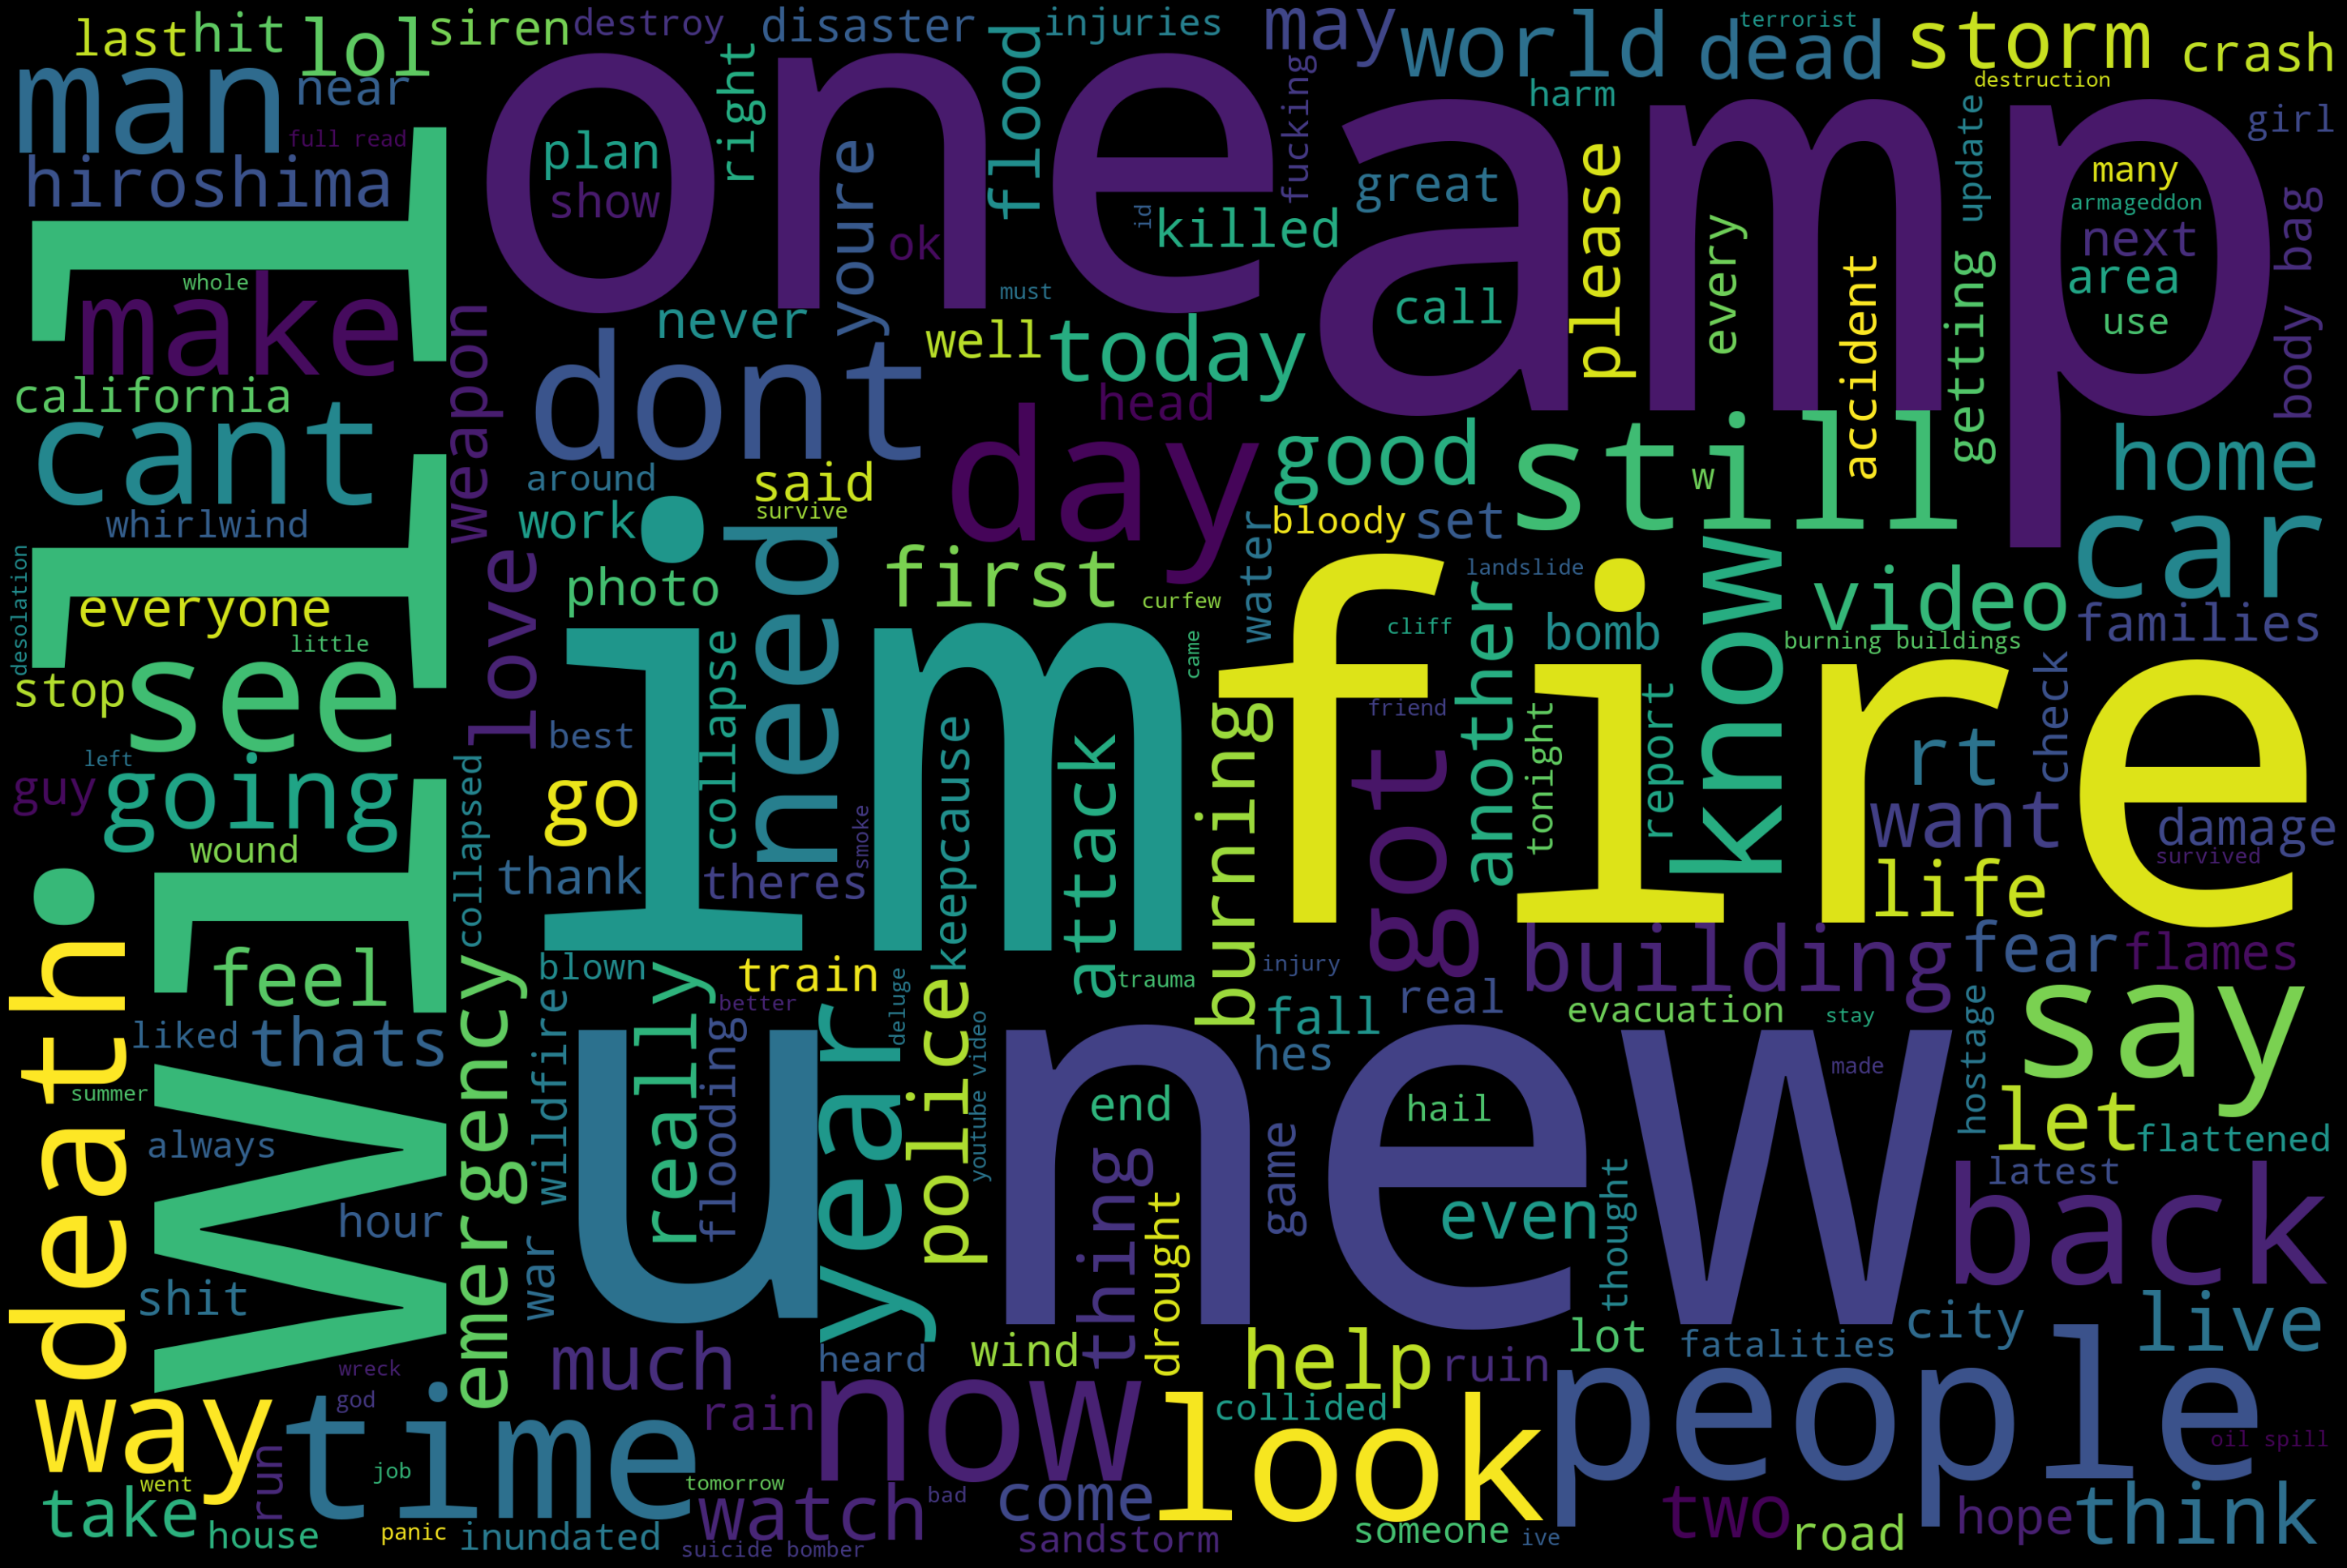

In [76]:
tweets_text = data['text'].str.split(' ')
tweet_data = [" ".join(tweet) for tweet in tweets_text]
all_texts = " ".join(tweet_data)

wordcloud_text = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(all_texts)


fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_text, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

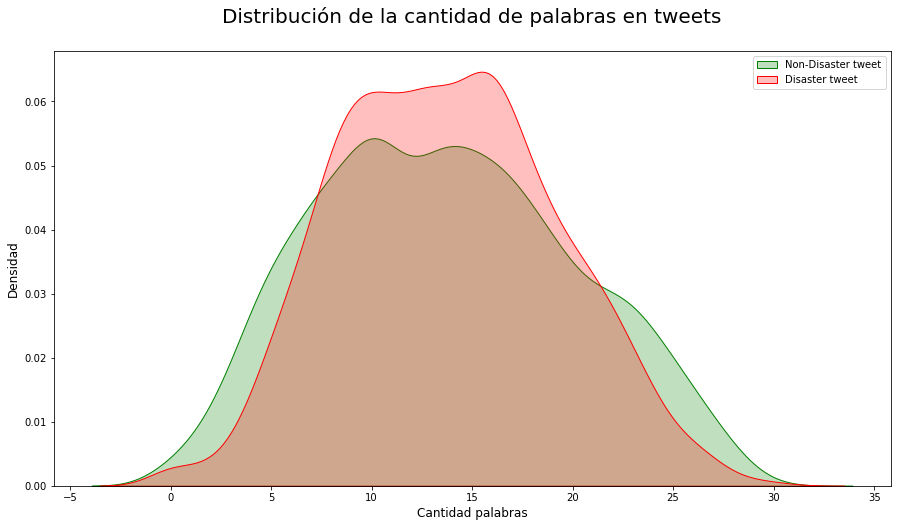

In [77]:
word_count = data['text'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(word_count[data['target'] == 0], shade = True, label = 'Non-Disaster tweet', color='Green')
sns.kdeplot(word_count[data['target'] == 1], shade = True, label = 'Disaster tweet', color='Red')

plt.title('Distribución de la cantidad de palabras en tweets\n', fontsize=20)
ax.legend()
plt.xlabel('Cantidad palabras', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

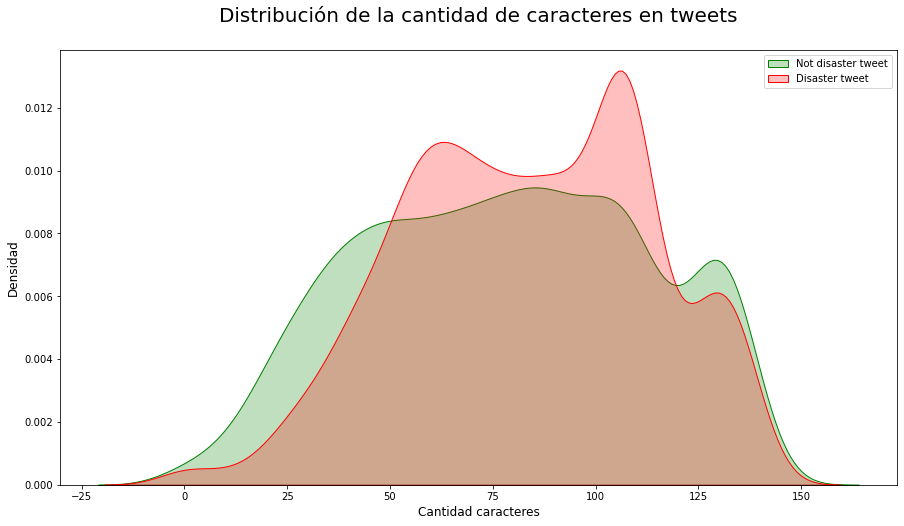

In [78]:
character_count = data['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize = (15, 8))
sns.kdeplot(character_count[data['target'] == 0], shade = True, label = 'Not disaster tweet', color='Green')
sns.kdeplot(character_count[data['target'] == 1], shade = True, label = 'Disaster tweet', color='Red')

plt.title('Distribución de la cantidad de caracteres en tweets\n', fontsize=20)
ax.legend()
plt.xlabel('Cantidad caracteres', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

### Target

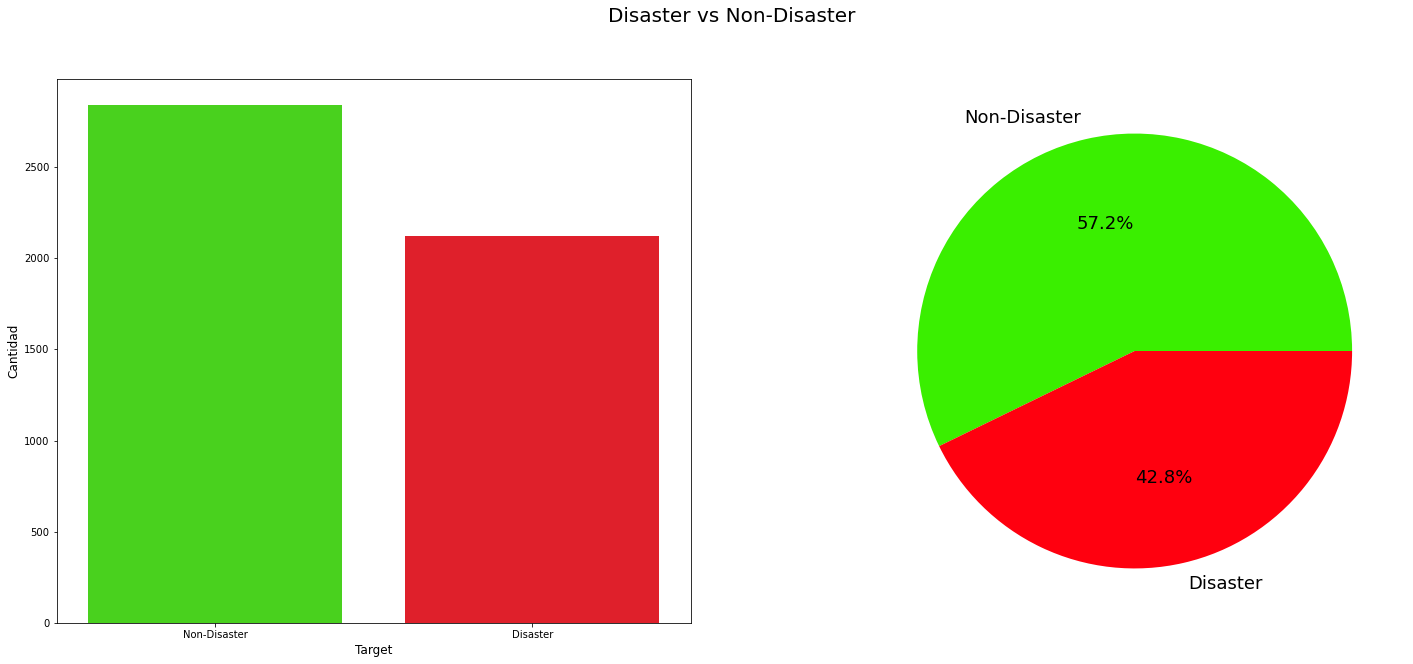

In [79]:
target_values = ['Non-Disaster', 'Disaster']
target = data['target'].value_counts()

fig, ax = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('Disaster vs Non-Disaster', fontsize=20)
colors = sns.color_palette('prism')

sns.barplot(x=target_values, y=target, palette=colors, ax=ax[0])
data.groupby('target').count()['id'].plot(kind='pie', ax=ax[1], labels=target_values, autopct="%.1f%%", colors = colors, fontsize=18)

ax[0].set_xlabel('Target', fontsize=12)
ax[0].set_ylabel('Cantidad', fontsize=12)
ax[1].set_ylabel('')

plt.show()

## Resumen de hallazgos

En general, encontramos que `fatalities`, `armagedon` y `deluge` son las palabras mas comunes en el dataset, pero luego de separar entre Desastres y No Desastres, las más comunes son `outbreak`, `debris` y `oil`.

Lasu ubicaciones mas comunes son en ciudades grandes de EEUU, tales como Nueva York, Los Angeles o Washington DC, pero tambien encontramos registros de Londres, Canada y Nigeria.

En cuanto a la distribucion de la cantidad de palabras y caracteres, tenemos que tanto en tweets de desastres como de no desastres, las variables adoptan una forma aproximada `Normal` con una media en 15 palabras y 80 caracteres.

Finalmente, en cuanto a la fragmentacion del dataset tenemos que un 57% de los tweets tratan de `No Desastres`, y el 43% tratan de `Desastres`.

## Conclusiones

<ul>
    <li>Encontramos que la mayor cantidad de tweets de desastres se generan en ciudades grandes como Nueva York, Londres o Los Angeles</li>
    <li>La distribucion de la cantidad de palabras y caracteres se acerca a una normal con media en 15 palabras (80 caracteres) por cada tweet.</li>
    <li>Las palabras mas comunes en tweets de desastres son <strong>outbreak</strong>, <strong>debris</strong> y <strong>oil</strong></li>
</ul>

## Modelos

In [80]:
# data.to_csv( "clean_data.csv", index=False)

### Bert

https://www.kaggle.com/andreshg/nlp-glove-bert-tf-idf-lstm-explained
https://www.kaggle.com/tuckerarrants/disaster-tweets-eda-glove-rnns-bert
https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
https://www.kaggle.com/anushakarthik1991/nlp-with-disaster-tweets-eda-cleaning-and-bert
https://www.kaggle.com/mitramir5/simple-bert-with-video
https://www.kaggle.com/c/nlp-getting-started/code?competitionId=17777&searchQuery=BERT

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [87]:
text = data['text']
target = data['target']

train_input_ids, train_attention_masks = bert_encode(text, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/willi/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [88]:
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [90]:
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Downloading: 100%|██████████| 570/570 [00:00<00:00, 295kB/s]
Downloading: 100%|██████████| 511M/511M [02:54<00:00, 3.07MB/s]
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [91]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]          

/Users/willi/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [92]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
398/398 [==============================] - 1518s 4s/step - loss: 0.4990 - accuracy: 0.7631 - val_loss: 0.4285 - val_accuracy: 0.8169
Epoch 2/3
398/398 [==============================] - 1802s 5s/step - loss: 0.3797 - accuracy: 0.8512 - val_loss: 0.4287 - val_accuracy: 0.8209
Epoch 3/3
398/398 [==============================] - 1612s 4s/step - loss: 0.2962 - accuracy: 0.8860 - val_loss: 0.4449 - val_accuracy: 0.8149


In [94]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

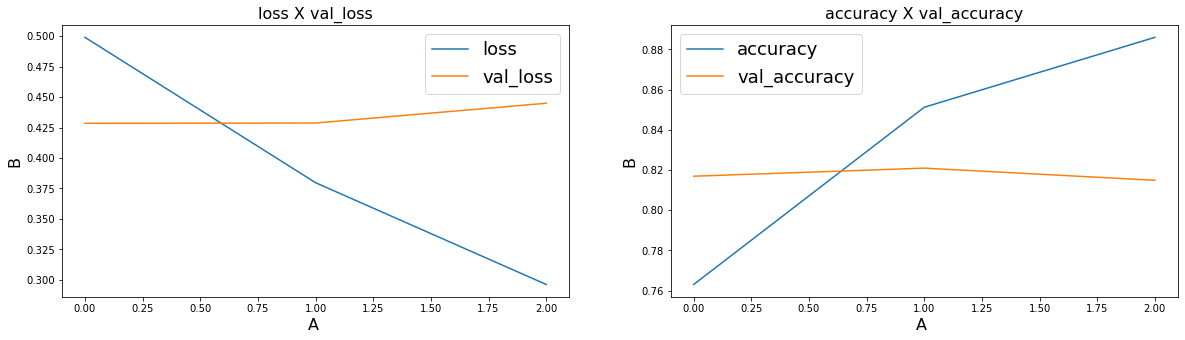

In [95]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])